# MÓDULO 4: LA CIENCIA DE DATOS Y LOS MODELOS DE ANALÍTICA PREDICTIVA EN LA INDUSTRIA 4.0

# 8- Otros métodos de aprendizaje: el kernel trick y aprendizaje por refuerzo

## Mountain car

En este ejemplo vamos a ver un problema estándar en Reinforcement Learning, es un entorno en el que un automóvil con poca potencia debe conducir cuesta arriba. Dado que la gravedad es más fuerte que el motor del automóvil, incluso a toda velocidad, el automóvil no puede simplemente acelerar cuesta arriba.

https://en.wikipedia.org/wiki/Mountain_car_problem

### Solución

Vamos a ver una solución al problema mediante el approach Q-learning. Para ello, consideramos los siguientes elementos propios de un problema de aprendizaje por refuerzo:

#### Observaciones:
Duplas (posición, velocidad):
* $\displaystyle Position=(-1.2,0.6)$ 
* $\displaystyle Velocity=(-0.07,0.07)$

#### Espacio de acciones:
* $\displaystyle motor=(left,neutral,right)$

#### Reward:
* $\displaystyle reward=-1$

#### Función de update, para cada time step:
* $\displaystyle Action=[-1,0,1]$
* $\displaystyle Velocity=Velocity+(Action)*0.001+\cos(3*Position)*(-0.0025)$
* $\displaystyle Position=Position+Velocity$

#### Condición inicial:
* $\displaystyle Position=-0.5$
* $\displaystyle Velocity=0.0$

#### Condición final, dada la cual daríamos por finalizada la simulación:
* $\displaystyle Position\geq 0.6$

### Importamos los paquetes necesarios

Necesitaremos el paquete 'OpenAI Gym':

- https://gym.openai.com/
- https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

### Cargamos el entorno

In [2]:
env = gym.envs.make("MountainCar-v0")

### Preprocesamos los datos

Estandarizamos los datos (normalizar a media 0 y varianza 1). Para ello, tomamos unos pocos datos del espacio de observaciones.

In [3]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
print(np.round(observation_examples, decimals=3))
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

[[-0.817 -0.037]
 [-0.323 -0.067]
 [-0.781  0.006]
 ...
 [-0.119 -0.002]
 [-0.76  -0.004]
 [-0.348 -0.   ]]


StandardScaler(copy=True, with_mean=True, with_std=True)

Convertimos un estado en características, usando kernels Gaussianos (RBF) con diferentes valores de $\gamma$ para tener datos diversos.

In [4]:
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

### Estimador

Definimos una serie de métodos que identifican cada posible accion dentro del entorno:
- featurize_state() => traduce estados en vectores de características (posición, velocidad)
- predict() => dados un estado y una acción (opcional), realiza predicciones
- update() => actualiza los parámetros de la clase 'Estimator', dados un estado y una acción a ejecutar

In [25]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

### Policy

Definimos la política greedy para generar las probabilidades de tomar cada acción. 

In [26]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action. float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

### Q-learning

Definimos el algoritmo de aprendizaje que vamos a aplicar.

In [31]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Q-Value TD Target
            # Off Policy: the learning agent learns the value function according to the action derived 
            # from another policy
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

### Training

Inicializamos el estimador y ejecutamos el algoritmo para un número de episodios concreto. No necesitamos un $\epsilon>0.0$ porque vamos a explorar todos los estados.

In [32]:
estimator = Estimator()
stats = q_learning(env, estimator, 100, epsilon=0.0)

Step 144 @ Episode 100/100 (-148.0)

### Plotting

Graficamos resultados obtenidos en términos de:
- coste
- estadísticas de los episodios

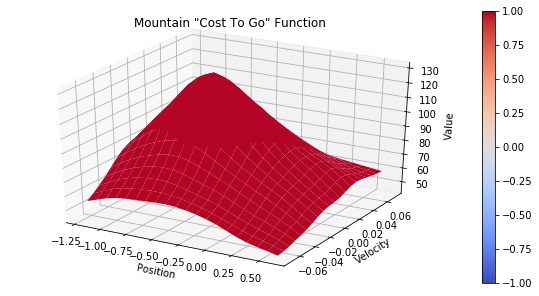

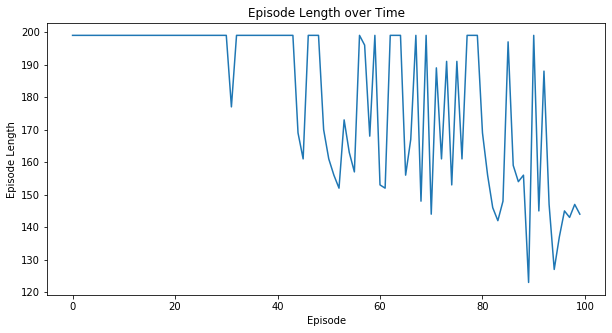

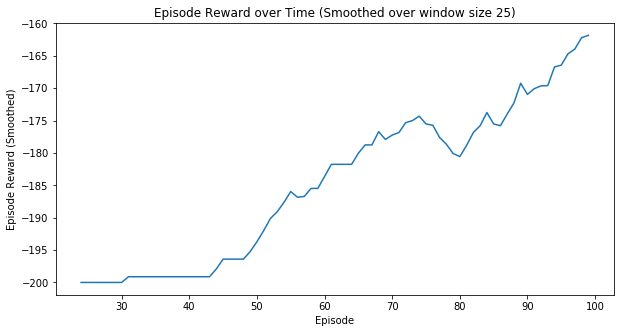

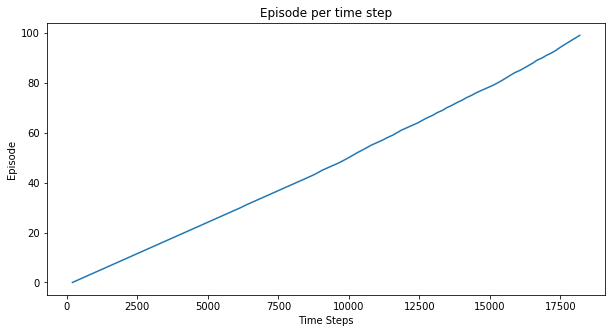

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [33]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)